In [164]:
# IMPORTANT: Must Run all the code cells step by step
# Create a folder "CSE440 Project" in "My Drive" and put all the required files there
# Required files: glove.6B.100d.txt, train.En.csv, task_A_En_test.csv, task_B_En_test.csv

# Mounting google drive to access the files (Must Run)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
# Importing all the necessary libraries (Must Run)

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support, precision_recall_curve
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, SimpleRNN
import seaborn as sns
from statistics import median

In [166]:
# Importing train and task A files from the "CSE440 Project" folder
url_train = '/content/drive/My Drive/CSE440 Project/train.En.csv'
url_test = '/content/drive/My Drive/CSE440 Project/task_A_En_test.csv'
train_dataset = pd.read_csv(url_train)
test_dataset = pd.read_csv(url_test)

In [167]:
# Filtering out the train and test dataset
train_dataset = train_dataset[train_dataset['tweet'].notnull()]
test_dataset = test_dataset[test_dataset['text'].notnull()]

# Seperating the dataset into corresponding variables
x_train, y_train, x_test, y_test = train_dataset['tweet'], train_dataset['sarcastic'], test_dataset['text'], test_dataset['sarcastic']

In [168]:
# Create a Tokenizer instance
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")  # num_words is the maximum number of words to keep

# Fit the tokenizer on the texts
tokenizer.fit_on_texts(x_train)

# Convert the texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad the sequences to a fixed length
max_sequence_length_train = max(len(seq) for seq in train_sequences)
max_sequence_length_test = max(len(seq) for seq in test_sequences)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)

padded_sequences_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post", truncating="post")
padded_sequences_test = pad_sequences(test_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

In [169]:
# Load pre-trained GloVe embeddings (Must Run)
glove_embeddings_index = {}

glove = '/content/drive/My Drive/CSE440 Project/glove.6B.100d.txt'
with open(glove, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [170]:
# GRU

def gru_function(y_train, y_test):

  # Build the GRU model with pre-trained embeddings
  model = Sequential([
      Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
      GRU(64),
      Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Define callbacks
  filePath = '/content/drive/My Drive/CSE440 Project/modelStoreGRU.h5'  # Specify the path for the model checkpoint
  checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  csv_logger = CSVLogger('/content/drive/My Drive/CSE440 Project/trainingGRU.log')
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [checkpoint, csv_logger, early_stopping]

  # Train the model
  model.fit(padded_sequences_train, y_train, epochs=500, validation_split=0.1, callbacks=callbacks_list)

  # Evaluate the model (replace with your test data)
  loss, accuracy = model.evaluate(padded_sequences_test, y_test)

  return loss, accuracy

In [171]:
# LSTM

def lstm_function(y_train, y_test):
  # Build the LSTM model with pre-trained embeddings
  model = Sequential([
      Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
      LSTM(64),
      Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  filePath = '/content/drive/My Drive/CSE440 Project/modelStoreLSTM.h5'  # Specify the path for the model checkpoint
  checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  csv_logger = CSVLogger('/content/drive/My Drive/CSE440 Project/trainingLSTM.log')
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [checkpoint, csv_logger, early_stopping]

  # Train Machine
  model.fit(padded_sequences_train, y_train, epochs=500, validation_split=0.1, callbacks=callbacks_list)

  # Evaluate the model
  loss, accuracy = model.evaluate(padded_sequences_test, y_test)

  return loss, accuracy

In [172]:
gru_loss, gru_accuracy =  gru_function(y_train, y_test)
lstm_loss, lstm_accuracy =  lstm_function(y_train, y_test)

Epoch 1/500
98/98 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7221
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/My Drive/CSE440 Project/modelStoreGRU.h5
98/98 [==============================] - 12s 98ms/step - loss: 0.6084 - accuracy: 0.7221 - val_loss: 0.3060 - val_accuracy: 1.0000
Epoch 2/500
98/98 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7221
Epoch 2: val_accuracy did not improve from 1.00000
98/98 [==============================] - 9s 91ms/step - loss: 0.5926 - accuracy: 0.7221 - val_loss: 0.3668 - val_accuracy: 1.0000
Epoch 3/500
98/98 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.7221
Epoch 3: val_accuracy did not improve from 1.00000
98/98 [==============================] - 10s 102ms/step - loss: 0.5927 - accuracy: 0.7221 - val_loss: 0.3394 - val_accuracy: 1.0000
Epoch 4/500
98/98 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7221


In [173]:
print("GRU loss:", round(gru_loss * 100, 2))
print("LSTM loss:", round(lstm_loss * 100, 2))

print("GRU accuracy:", round(gru_accuracy * 100, 2))
print("LSTM accuracy:", round(lstm_accuracy * 100, 2))

GRU loss: 48.5
LSTM loss: 46.06
GRU accuracy: 85.71
LSTM accuracy: 85.64


In [174]:
# Task A calculate precision, recall, f1 and confusion matrix

# Load trained model
model = load_model('/content/drive/My Drive/CSE440 Project/modelStoreLSTM.h5')

# Get predictions using model.predict
y_pred = model.predict(padded_sequences_test)

# Calculate threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_index = np.argmax(f1_scores)
threshold = thresholds[best_f1_index]

# Convert probabilities to class labels
y_pred = (y_pred > threshold).astype(int)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1)

44/44 [==============================] - 2s 24ms/step


In [175]:
print("precision_score:", round(precision[0], 2))
print("recall:", round(recall[0], 2))
print("F1_score:", round(f1[0], 2))

precision_score: 0.9
recall: 0.8
F1_score: 0.85


<Axes: >

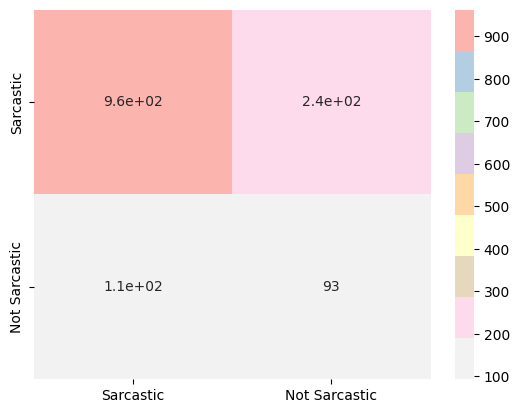

In [176]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Pastel1_r', xticklabels=['Sarcastic' ,'Not Sarcastic'],yticklabels=['Sarcastic' ,'Not Sarcastic'])

In [177]:
###### TASK B ######
# Calculate for 6 features

train = '/content/drive/My Drive/CSE440 Project/train.En.csv'
test = '/content/drive/My Drive/CSE440 Project/task_B_En_test.csv'
train_dataset = pd.read_csv(train)
test_dataset = pd.read_csv(test)

train_dataset = train_dataset[train_dataset['tweet'].notnull()]
test_dataset = test_dataset[test_dataset['text'].notnull()]

In [178]:
# Filtering out train and test data
x_train, y_train = train_dataset['rephrase'], pd.concat([train_dataset['sarcasm'], train_dataset['irony'], train_dataset['satire'], train_dataset['understatement'], train_dataset['overstatement'], train_dataset['rhetorical_question']], axis=1)
x_train, y_train = x_train.dropna(), y_train.dropna()

x_test, y_test = test_dataset['text'], pd.concat([test_dataset['sarcasm'], test_dataset['irony'], test_dataset['satire'], test_dataset['understatement'],  test_dataset['overstatement'], test_dataset['rhetorical_question']], axis=1)
x_test, y_test = x_test.dropna(), y_test.dropna()

# Train features: sarcasm, irony, satire, understatement, overstatement, rhetorical_question
y_train_sarcasm, y_train_irony, y_train_satire, y_train_understatement, y_train_overstatement, y_train_question = y_train['sarcasm'], y_train['irony'], y_train['satire'], y_train['understatement'], y_train['overstatement'], y_train['rhetorical_question']

# Test features: sarcasm, irony, satire, understatement, overstatement, rhetorical_question
y_test_sarcasm, y_test_irony, y_test_satire, y_test_understatement, y_test_overstatement, y_test_question = y_test['sarcasm'], y_test['irony'], y_test['satire'], y_test['understatement'], y_test['overstatement'], y_test['rhetorical_question']

In [179]:
# Create a Tokenizer instance
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")  # num_words is the maximum number of words to keep

# Fit the tokenizer on the texts
tokenizer.fit_on_texts(x_train)

# Convert the texts to sequences of integers
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad the sequences to a fixed length
max_sequence_length_train = max(len(seq) for seq in train_sequences)
max_sequence_length_test = max(len(seq) for seq in test_sequences)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)
padded_sequences_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

padded_sequences_test = pad_sequences(test_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

In [180]:
# Load pre-trained GloVe embeddings (MUST RUN!)
glove_embeddings_index = {}

glove = '/content/drive/My Drive/CSE440 Project/glove.6B.100d.txt'
with open(glove, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# LSTM function
def lstm_function(y_train, y_test, feature):
  # Build the LSTM model with pre-trained embeddings
  model = Sequential([
      Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
      LSTM(64),
      Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  filePath = f'/content/drive/My Drive/CSE440 Project/{feature}ModelStoreLSTM.h5'  # Specify the path for the model checkpoint
  checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  csv_logger = CSVLogger(f'/content/drive/My Drive/CSE440 Project/{feature}TrainingLSTM.log')
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [checkpoint, csv_logger, early_stopping]

  # Train Machine
  model.fit(padded_sequences_train, y_train, epochs=500, validation_split=0.1, callbacks=callbacks_list)

  # Evaluate the model
  loss, accuracy = model.evaluate(padded_sequences_test, y_test)

  return loss, accuracy

In [181]:
# Loss and Accuracy of the 6 features
sarcasm_loss, sarcasm_accuracy = lstm_function(y_train_sarcasm, y_test_sarcasm, 'sarcasm') # Sarcasm
irony_loss, irony_accuracy = lstm_function(y_train_irony, y_test_irony, 'irony') # Irony
satire_loss, satire_accuracy = lstm_function(y_train_satire, y_test_satire, 'satire') # Satire
understatement_loss, understatement_accuracy = lstm_function(y_train_understatement, y_test_understatement, 'understatement') # Understatement
overstatement_loss, overstatement_accuracy = lstm_function(y_train_overstatement, y_test_overstatement, 'overstatement') # Overstatement
question_loss, question_accuracy = lstm_function(y_train_question, y_test_question, 'rhetoricalQuestion') # Rhetorical Question

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7910
Epoch 1: val_accuracy improved from -inf to 0.83908, saving model to /content/drive/My Drive/CSE440 Project/sarcasmModelStoreLSTM.h5
25/25 [==============================] - 7s 133ms/step - loss: 0.5904 - accuracy: 0.7910 - val_loss: 0.4691 - val_accuracy: 0.8391
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8205
Epoch 2: val_accuracy did not improve from 0.83908
25/25 [==============================] - 2s 81ms/step - loss: 0.4806 - accuracy: 0.8205 - val_loss: 0.4619 - val_accuracy: 0.8391
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8205
Epoch 3: val_accuracy did not improve from 0.83908
25/25 [==============================] - 2s 84ms/step - loss: 0.4746 - accuracy: 0.8205 - val_loss: 0.4448 - val_accuracy: 0.8391
Epoch 4/500
25/25 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0

In [182]:
print("Sarcasm Accuracy:", round(sarcasm_accuracy*100, 2))
print("Irony Accuracy:", round(irony_accuracy*100, 2))
print("Satire Accuracy:", round(satire_accuracy*100, 2))
print("Understatement Accuracy:", round(understatement_accuracy*100, 2))
print("Overstatement Accuracy:", round(overstatement_accuracy*100, 2))
print("Rhetorical Question Accuracy:", round(question_accuracy*100, 2))
print()
print("Sarcasm Loss:", round(sarcasm_loss*100, 2))
print("Irony Loss:", round(irony_loss*100, 2))
print("Satire Loss:", round(satire_loss*100, 2))
print("Understatement Loss:", round(understatement_loss*100, 2))
print("Overstatement Loss:", round(overstatement_loss*100, 2))
print("Rhetorical Question Loss:", round(question_loss*100, 2))

Sarcasm Accuracy: 12.86
Irony Accuracy: 98.57
Satire Accuracy: 96.5
Understatement Accuracy: 99.93
Overstatement Accuracy: 99.29
Rhetorical Question Accuracy: 99.21

Sarcasm Loss: 148.68
Irony Loss: 24.11
Satire Loss: 15.18
Understatement Loss: 1.83
Overstatement Loss: 7.47
Rhetorical Question Loss: 12.74


In [183]:
# Task B calculate precision, recall, f1 and confusion matrix

def precision_recall_f1_cm(feature, y_test):
  # Load trained model
  model = load_model(f'/content/drive/My Drive/CSE440 Project/{feature}ModelStoreLSTM.h5')

  # Get predictions using model.predict
  y_pred = model.predict(padded_sequences_test)

  # Calculate threshold
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
  best_f1_index = np.argmax(f1_scores)
  threshold = thresholds[best_f1_index]

  # Convert probabilities to class labels
  y_pred = (y_pred > threshold).astype(int)


  precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1)
  cm = confusion_matrix(y_test, y_pred)

  return precision[0], recall[0], f1[0], cm

44/44 [==============================] - 2s 26ms/step
sarcasm precision: 0.9245
sarcasm recall: 0.7623
sarcasm f1 Score: 0.8356


<Axes: >

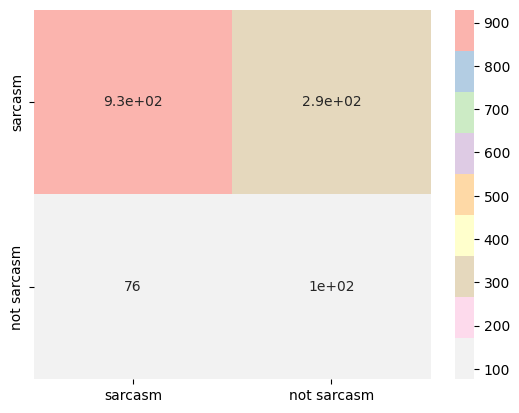

In [184]:
# Sarcasm Output
sarcasm_precision, sarcasm_recall, sarcasm_f1, sarcasm_cm = precision_recall_f1_cm('sarcasm', y_test_sarcasm)
print("sarcasm precision:", round(sarcasm_precision, 4))
print("sarcasm recall:", round(sarcasm_recall, 4))
print("sarcasm f1 Score:", round(sarcasm_f1, 4))
sns.heatmap(sarcasm_cm, annot=True, cmap='Pastel1_r', xticklabels=['sarcasm' ,'not sarcasm'],yticklabels=['sarcasm' ,'not sarcasm'])

44/44 [==============================] - 2s 31ms/step
irony precision: 0.9872
irony recall: 0.4457
irony f1 Score: 0.6141


<Axes: >

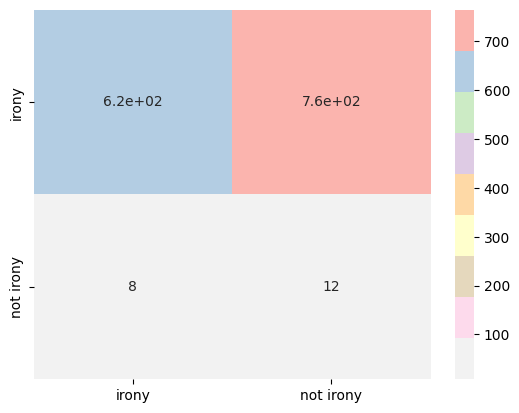

In [185]:
# Irony Output

irony_precision, irony_recall, irony_f1, irony_cm = precision_recall_f1_cm('irony', y_test_irony)
print("irony precision:", round(irony_precision, 4))
print("irony recall:", round(irony_recall, 4))
print("irony f1 Score:", round(irony_f1, 4))
sns.heatmap(irony_cm, annot=True, cmap='Pastel1_r', xticklabels=['irony' ,'not irony'],yticklabels=['irony' ,'not irony'])

44/44 [==============================] - 2s 25ms/step
satire precision: 0.9286
satire recall: 0.0192
satire f1 Score: 0.0377


<Axes: >

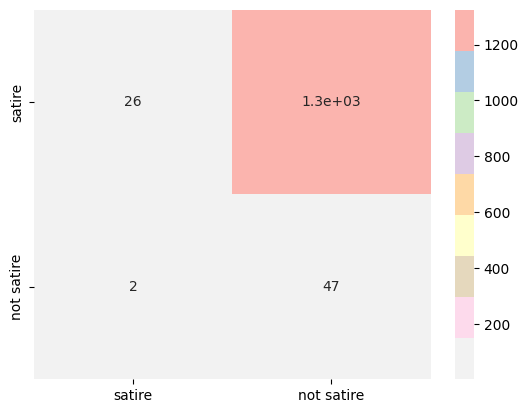

In [186]:
# Satire Output

satire_precision, satire_recall, satire_f1, satire_cm = precision_recall_f1_cm('satire', y_test_satire)
print("satire precision:", round(satire_precision, 4))
print("satire recall:", round(satire_recall, 4))
print("satire f1 Score:", round(satire_f1, 4))
sns.heatmap(satire_cm, annot=True, cmap='Pastel1_r', xticklabels=['satire' ,'not satire'],yticklabels=['satire' ,'not satire'])

44/44 [==============================] - 2s 26ms/step
understatement precision: 0.9993
understatement recall: 0.9736
understatement f1 Score: 0.9862


<Axes: >

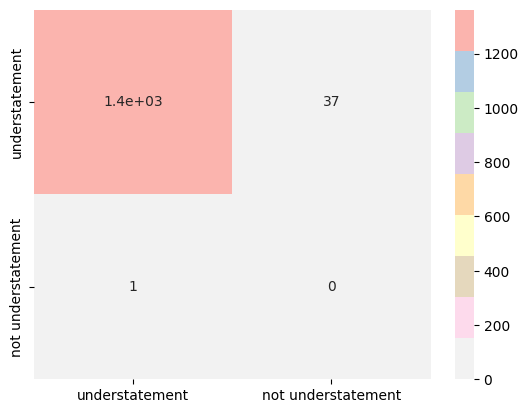

In [187]:
# Understatement Output

understatement_precision, understatement_recall, understatement_f1, understatement_cm = precision_recall_f1_cm('understatement', y_test_understatement)
print("understatement precision:", round(understatement_precision, 4))
print("understatement recall:", round(understatement_recall, 4))
print("understatement f1 Score:", round(understatement_f1, 4))
sns.heatmap(understatement_cm, annot=True, cmap='Pastel1_r', xticklabels=['understatement' ,'not understatement'],yticklabels=['understatement' ,'not understatement'])

44/44 [==============================] - 2s 25ms/step
overstatement precision: 0.0
overstatement recall: 0.0
overstatement f1 Score: 0.0


<Axes: >

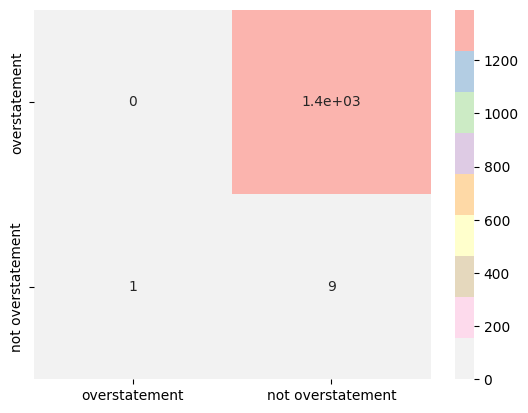

In [188]:
# Overstatement Output

overstatement_precision, overstatement_recall, overstatement_f1, overstatement_cm = precision_recall_f1_cm('overstatement', y_test_overstatement)
print("overstatement precision:", round(overstatement_precision, 4))
print("overstatement recall:", round(overstatement_recall, 4))
print("overstatement f1 Score:", round(overstatement_f1, 4))
sns.heatmap(overstatement_cm, annot=True, cmap='Pastel1_r', xticklabels=['overstatement' ,'not overstatement'],yticklabels=['overstatement' ,'not overstatement'])

44/44 [==============================] - 2s 36ms/step
rhetorical question precision: 0.9919
rhetorical question recall: 0.9726
rhetorical question f1 Score: 0.9822


<Axes: >

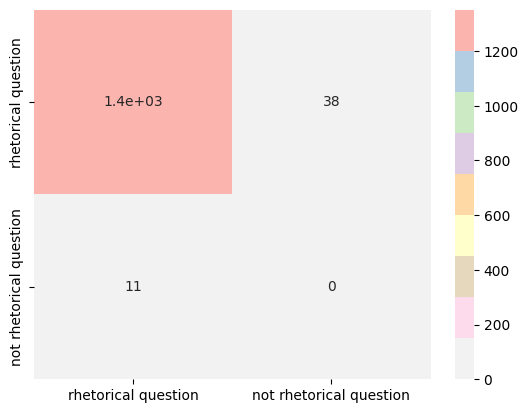

In [189]:
# Rhetorical Question Output

question_precision, question_recall, question_f1, question_cm = precision_recall_f1_cm('rhetoricalQuestion', y_test_question)
print("rhetorical question precision:", round(question_precision, 4))
print("rhetorical question recall:", round(question_recall, 4))
print("rhetorical question f1 Score:", round(question_f1, 4))
sns.heatmap(question_cm, annot=True, cmap='Pastel1_r', xticklabels=['rhetorical question' ,'not rhetorical question'],yticklabels=['rhetorical question' ,'not rhetorical question'])